# Did elimination of copayment increase visits to the physician?

Inspired by this YouTube [video](https://www.youtube.com/watch?v=EgIU1_qZ5Lc&list=WL&index=76&t=251s).

An illustration of how to apply the difference in difference method in Python

Hans Olav Melberg, University of Oslo

For a more comprehensive and detailed study analysis on the same issue with the same dataset, look at his jupyter notebook https://github.com/hmelberg/causal/blob/master/archive/visits.ipynb

### Introduction

In 2010 Norway eliminated copayment for visiting a physicial for everybody below 16 years old. Before 2010 the thrshold for copayment was 12. This means that those between 12 and 16 now could go to the doctor with no copayment. The question is then: Did the reform increase their number of visits and if so, by how much? In this paper we focus mainly on one method of answering the question: The difference-in-difference method. The intuition is to compare the trend for the group that is affected with a groups that has a common trend before the reform, but who is not affected by the reform.

![J7P3p[1].png](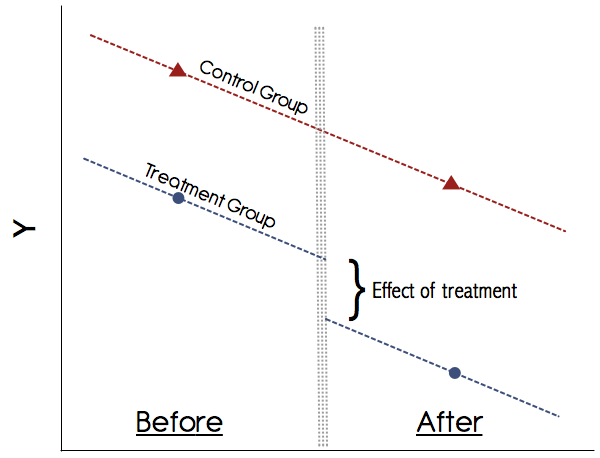)(https://i.stack.imgur.com/J7P3p.png)

In [ ]:
# Import tools
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# read file
file="https://www.dropbox.com/s/5w4l7fvus79wvew/femaleVisitsToPhysician.csv?dl=1"
df=pd.read_csv(file)

In [ ]:
df

,Unnamed: 0,year,age,sex,consultations,population,perCapita
0,4,2006,1,f,67194.0,28221.0,2.380993
1,7,2006,2,f,49802.0,28361.0,1.756003
2,10,2006,3,f,42741.0,27899.0,1.531990
3,13,2006,4,f,36555.0,28420.0,1.286242
4,16,2006,5,f,33319.0,29479.0,1.130262
...,...,...,...,...,...,...,...
707,2543,2013,85,f,50876.0,10696.0,4.756545
708,2546,2013,86,f,46102.0,10393.0,4.435870
709,2548,2013,87,f,41468.0,9243.0,4.486422
710,2550,2013,88,f,35440.0,8763.0,4.044277


In [ ]:
# for some reason I liked to work with a variable called visits instead of consultations
df['visits']=df.consultations
df.head()

,Unnamed: 0,year,age,sex,consultations,population,perCapita,visits
0,4,2006,1,f,67194.0,28221.0,2.380993,67194.0
1,7,2006,2,f,49802.0,28361.0,1.756003,49802.0
2,10,2006,3,f,42741.0,27899.0,1.531990,42741.0
3,13,2006,4,f,36555.0,28420.0,1.286242,36555.0
4,16,2006,5,f,33319.0,29479.0,1.130262,33319.0


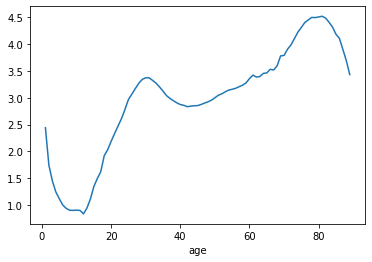

In [ ]:
# find average number of visits in different age groups
df.groupby('age')['perCapita'].mean().plot();

In [ ]:
# see if there is a time trend for 14 year olds
# create a dataframe with only 14 year olds
df14 = df.query('age==14')
df14

,Unnamed: 0,year,age,sex,consultations,population,perCapita,visits
13,43,2006,14,f,29129.0,30927.0,0.941863,29129.0
102,399,2007,14,f,29563.0,30464.0,0.970424,29563.0
191,752,2008,14,f,29848.0,30578.0,0.976127,29848.0
280,1100,2009,14,f,31140.0,30755.0,1.012518,31140.0
369,1439,2010,14,f,36296.0,30983.0,1.171481,36296.0
458,1774,2011,14,f,39799.0,31522.0,1.262579,39799.0
547,2087,2012,14,f,38880.0,31080.0,1.250965,38880.0
636,2369,2013,14,f,39609.0,30559.0,1.296148,39609.0


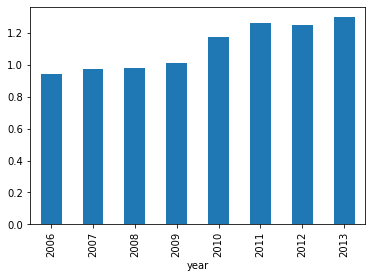

In [ ]:
# set year as index to get it on the x-scale
df14.set_index('year').perCapita.plot.bar();

In [ ]:
# Now: Want to create a graph that compared the change over time for 14 and 25 year olds
df2 = df.query('age==14 or age==25')

In [ ]:
# focus on only those three variables
df2 = df2[['year', 'age', 'perCapita']]

df2.head()

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127


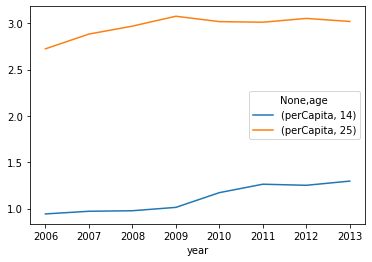

In [ ]:
# one way of getting a graph
df2.set_index(['year', 'age']).unstack('age').plot();

In [ ]:
# Now: Shape the dataset so we can run a difference-in-difference
# Compare 14 year olds to, for instance, 25 year olds (You should probably use a control group that is closer in age!)

df14and25 = df2.set_index(['year', 'age']).unstack('age')
df14and25

perCapita          
age         14        25
year                    
2006  0.941863  2.724488
2007  0.970424  2.883638
2008  0.976127  2.969386
2009  1.012518  3.076277
2010  1.171481  3.018165
2011  1.262579  3.011706
2012  1.250965  3.052795
2013  1.296148  3.019887

In [ ]:
# create a variable that represent the reform (0 before the reform, 1 after)
df14and25['copay'] = 0

In [ ]:
df14and25['copay'] = df14and25.copay.where(df14and25.index<2010, 1)

In [ ]:
df14and25

perCapita           copay
age         14        25      
year                          
2006  0.941863  2.724488     0
2007  0.970424  2.883638     0
2008  0.976127  2.969386     0
2009  1.012518  3.076277     0
2010  1.171481  3.018165     1
2011  1.262579  3.011706     1
2012  1.250965  3.052795     1
2013  1.296148  3.019887     1

In [ ]:
# compare groups means
result = df14and25.groupby('copay').mean()
result

perCapita          
age          14        25
copay                    
0      0.975233  2.913447
1      1.245293  3.025638

In [ ]:
result.columns = ['age_14', 'age_25']

In [ ]:
result

,age_14,age_25
copay,,
0,0.975233,2.913447
1,1.245293,3.025638


In [ ]:
result['age_25'] - result['age_14']

copay
0    1.938214
1    1.780345
dtype: float64

In [ ]:
(result['age_25'] - result['age_14']).diff()

#-0.157869 means that the difference between the two groups became smaller 

copay
0         NaN
1   -0.157869
dtype: float64

In [ ]:
# Now lets run a diff-in-diff regression

In [ ]:
df2

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127
202,2008,25,2.969386
280,2009,14,1.012518
291,2009,25,3.076277
369,2010,14,1.171481
380,2010,25,3.018165


In [ ]:
# create new variable
df2['copay']=0
df2['copay']=df2['copay'].where(df2.year<2010,1)
df2

,year,age,perCapita,copay
13,2006,14,0.941863,0
24,2006,25,2.724488,0
102,2007,14,0.970424,0
113,2007,25,2.883638,0
191,2008,14,0.976127,0
202,2008,25,2.969386,0
280,2009,14,1.012518,0
291,2009,25,3.076277,0
369,2010,14,1.171481,1
380,2010,25,3.018165,1


In [ ]:
df2['age_14'] = np.where(df2.age==14,1,0)
df2

,year,age,perCapita,copay,age_14
13,2006,14,0.941863,0,1
24,2006,25,2.724488,0,0
102,2007,14,0.970424,0,1
113,2007,25,2.883638,0,0
191,2008,14,0.976127,0,1
202,2008,25,2.969386,0,0
280,2009,14,1.012518,0,1
291,2009,25,3.076277,0,0
369,2010,14,1.171481,1,1
380,2010,25,3.018165,1,0


# difference in difference model (example)

In [ ]:
#outcome = treated dummy + after intervention + affected by * after dummy (+ other_variables)

#visits = being_14 + after2010 + being_14 * after2010

model = 'perCapita ~ age_14 + copay + copay * age_14 + year'

In [ ]:
mod = smf.ols(formula=model, data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              perCapita   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     987.2
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           5.65e-14
Time:                        06:32:21   Log-Likelihood:                 25.410
No. Observations:                  16   AIC:                            -40.82
Df Residuals:                      11   BIC:                            -36.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -85.7891     26.764     -3.205   

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


So, did the reform have an effect? Yes, loook at the **interaction term** (0.1579): the number of visits went up by 0.15 for the 14 years old people.

# Synthetic control

In the difference-in-difference model we compared the 14 year olds to the 10 year olds. We could have compared against 8,9, 10, 11, 17 or many other age groups. The idea behind synthetic control is that instead of just selecting one group, we allow the computer to select a combination of the other possible comparisons. We would like to select a comparsion with a good fit between out group (the 14 year olds) so we first run a regression to determin what combination of the other groups that best predict visits amoung 14 year olds.

In [ ]:
#create a new dataframe (copies the old one)
df3 = df.set_index(['age', 'year'])
# focus on only one variable and unstack age
df3 = df3['perCapita'].copy()
df3 = df3.unstack('age')
# change the column names so there is a "age" in front of each number/age
cols = df3.columns.tolist()
cols2 = ['age'+str(x) for x in cols]
df3.columns = cols2
df3

,age1,age2,age3,age4,age5,age6,age7,age8,age9,age10,age11,age12,age13,age14,age15,age16,age17,age18,age19,age20,age21,age22,age23,age24,age25,age26,age27,age28,age29,age30,age31,age32,age33,age34,age35,age36,age37,age38,age39,age40,...,age50,age51,age52,age53,age54,age55,age56,age57,age58,age59,age60,age61,age62,age63,age64,age65,age66,age67,age68,age69,age70,age71,age72,age73,age74,age75,age76,age77,age78,age79,age80,age81,age82,age83,age84,age85,age86,age87,age88,age89
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006,2.380993,1.756003,1.531990,1.286242,1.130262,1.043215,0.937359,0.873136,0.858985,0.868799,0.849691,0.722668,0.820439,0.941863,1.156837,1.363449,1.442006,1.753309,1.907719,2.081484,2.203548,2.346865,2.400633,2.615014,2.724488,2.891456,3.049334,3.117134,3.135749,3.153024,3.109401,3.159167,3.039841,2.983835,2.989462,2.838083,2.866101,2.817606,2.706652,2.724275,...,2.883707,2.950519,2.905929,3.030327,3.057850,2.975248,3.049998,3.069014,3.085489,3.132656,3.463541,3.338520,3.450796,3.260139,3.451295,3.100947,3.364834,3.302275,3.402686,3.579533,3.587750,3.648417,3.627753,3.626299,3.867027,4.005107,4.122325,3.973922,4.141395,4.010851,4.123875,3.965629,3.960705,3.860691,3.968094,3.556138,4.206420,3.147521,3.150849,2.916353
2007,2.349824,1.720274,1.479736,1.255660,1.101836,0.970258,0.911899,0.860227,0.836315,0.841659,0.841283,0.709988,0.795714,0.970424,1.160902,1.405715,1.548657,1.800630,2.028248,2.195718,2.342746,2.455907,2.567556,2.676331,2.883638,2.963744,3.036797,3.237252,3.244054,3.255836,3.215673,3.137500,3.177651,3.040654,2.979322,2.986654,2.827512,2.865022,2.827131,2.767400,...,2.879163,2.989468,3.031078,2.988972,3.090060,3.108705,3.025781,3.115156,3.120474,3.143833,3.194372,3.559762,3.322858,3.501596,3.315542,3.463113,3.160492,3.369812,3.450101,3.606829,3.677110,3.708258,3.800666,3.809014,3.793509,3.990251,4.150520,4.266445,4.129405,4.222778,4.041214,4.190433,4.027815,4.013758,3.921695,3.908281,3.520630,4.126422,3.057895,2.980796
2008,2.425987,1.776511,1.441581,1.242319,1.128775,0.976961,0.903234,0.884323,0.879862,0.849325,0.858647,0.743828,0.838632,0.976127,1.210946,1.425913,1.581745,1.912368,2.055867,2.293678,2.408762,2.556205,2.659220,2.855937,2.969386,3.126485,3.186232,3.276910,3.383772,3.411793,3.352591,3.266009,3.163188,3.220910,3.073958,3.021801,3.000485,2.876266,2.895027,2.843920,...,2.950815,2.980008,3.059487,3.090605,3.048215,3.138689,3.170747,3.091074,3.172557,3.211888,3.243650,3.305529,3.556023,3.336126,3.543774,3.391921,3.552554,3.212387,3.553533,3.697777,3.747836,3.841466,3.882927,4.023301,4.019833,4.032701,4.196414,4.373799,4.428428,4.237253,4.348818,4.167618,4.305228,4.128127,4.019493,3.906837,3.915012,3.482036,4.091460,2.978837
2009,2.419597,1.689157,1.455040,1.231516,1.111600,0.998242,0.923751,0.885573,0.899388,0.895769,0.865630,0.751757,0.864011,1.012518,1.213147,1.435561,1.568107,1.883245,2.078847,2.232271,2.454302,2.526034,2.655429,2.845889,3.076277,3.071915,3.233469,3.280347,3.398499,3.416510,3.420074,3.320811,3.260391,3.149772,3.150453,3.009062,2.948054,2.961365,2.832467,2.864613,...,2.933117,2.975072,3.004381,3.054044,3.082579,3.068295,3.139951,3.178686,3.094295,3.192911,3.215665,3.266945,3.223286,3.513051,3.332822,3.553922,3.419175,3.513978,3.298016,3.722511,3.715953,3.872319,3.995600,4.027179,4.182720,4.094386,4.145161,4.324541,4.458963,4.563151,4.290282,4.439528,4.186211,4.307975,4.130794,3.984670,3.881486,3.822676,3.386757,3.838513
2010,2.630705,1.783554,1.405735,1.229607,1.062639,0.969444,0.920764,0.871256,0.864848,0.888103,0.900745,0.864608,0.983088,1.171481,1.396151,1.489255,1.642744,1.910304,2.043471,2.227106,2.334668,2.529313,2.664595,2.823017,3.018165,3.113292,3.150057,3.341761,3.371827,3.394332,3.447067,3.413018,3.285020,3.201441,3.092390,3.117406,2.978988,2.935667,2.993396,2.863392,...,2.983537,3.041035,3.085808,3.107003,3.170299,3.209908,3.139672,3.258398,3.294474,3.238988,3.319337,3.345237,3.297141,3.340068,3.691694,3.501835,3.770404,

                            OLS Regression Results                            
Dep. Variable:                  age14   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     1.638
Date:                Fri, 04 Jun 2021   Prob (F-statistic):              0.484
Time:                        06:49:24   Log-Likelihood:                 11.964
No. Observations:                   4   AIC:                            -17.93
Df Residuals:                       1   BIC:                            -19.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8432      2.306      1.233      0.4

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


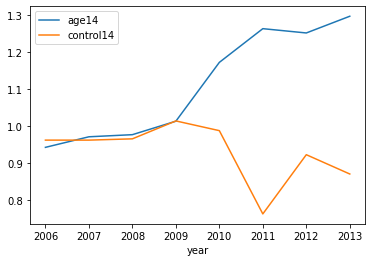

In [ ]:
import statsmodels.formula.api as smf

model = 'age14 ~ age8 + age9'
mod = smf.ols(model, data=df3[df3.index<2010])
res = mod.fit()
print (res.summary())

# after determinig the importance of the other groups, 
# we use the results of the model to predic what the pattern 
# should be after the reform (if it follows the same pattern as previously)

df3['control14'] = res.predict(exog = df3)

# the difference between the predicted visits and observed visits (for 14 
# year olds) is the impact of the reform. We plot this.

df3[['age14', 'control14']].plot()